In [110]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import seaborn as sns
import pprint
import operator
import time
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder

from utils.constants import PATH_DATA_CUST, PATH_DATA_AZD
from utils.helper import missing_summary, display_side_by_side
from utils import (read_data,
                   listtodict,
                  codetonan,
                  get_unknown,
                  encode_df)

%matplotlib inline

import warnings
#warnings.filterwarnings("ignore")

### General Population

In [2]:
azdias_file = '../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv'
azdias = read_data(PATH_DATA_AZD, portion=0.1)
azdias.head(3)

Total rows in file: 891221
Extracting 89122 rows from file.
Loading File...


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Loading succeed. Time used: 11 seconds.


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
1,645169,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
2,796661,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,2


In [3]:
print('Rows and Columns of general population: {}'.format(azdias.shape))

Rows and Columns of general population: (89122, 366)


In [5]:
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

### Customer

In [4]:
customers_file = '../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv'
customers = read_data(PATH_DATA_CUST, portion=0.1)
customers.head(3)

Total rows in file: 191652
Extracting 19165 rows from file.
Loading File...
Loading succeed. Time used: 2 seconds.


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
1,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
2,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4


In [5]:
print('Rows and Columns of Arvato Customer: {}'.format(customers.shape))

Rows and Columns of Arvato Customer: (19165, 369)


In [53]:
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

columns differences in Customers and General Population dataset

In [6]:
customer_info = customers.columns.difference(azdias.columns)
customer_info

Index(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype='object')

### Missing value code summary

In [7]:
unknown_code = get_unknown()
unknown_code.head(5)

,missing_or_unknown,Description
AGER_TYP,[-1],best-ager typology
ALTERSKATEGORIE_GROB,"[-1, 0]",age through prename analysis
ALTER_HH,[0],main age within the household
ANREDE_KZ,"[-1, 0]",gender
BALLRAUM,[-1],distance to the next metropole


change this value with missing code as np.nan.

In [55]:
unknown_code.index.rename('Attribute', inplace=True)

In [56]:
unknown_code.reset_index().to_csv('unknown_summary.csv')

In [8]:
codetonan(azdias, unknown_code)

Total execution time of this procedure: 0.40 seconds


In [9]:
codetonan(customers, unknown_code)

Total execution time of this procedure: 0.13 seconds


### Missing values in Columns

In [10]:
azdias_nareport = missing_summary(azdias)
customers_nareport = missing_summary(customers)
nastats = pd.DataFrame(np.column_stack([azdias_nareport['Level.of.na'].value_counts(), 
                              customers_nareport['Level.of.na'].value_counts()]),
            columns=['Azdias', 'Customers'],
            index=['Low', 'Zero', 'High'])
nastats

,Azdias,Customers
Low,269,267
Zero,87,90
High,10,12


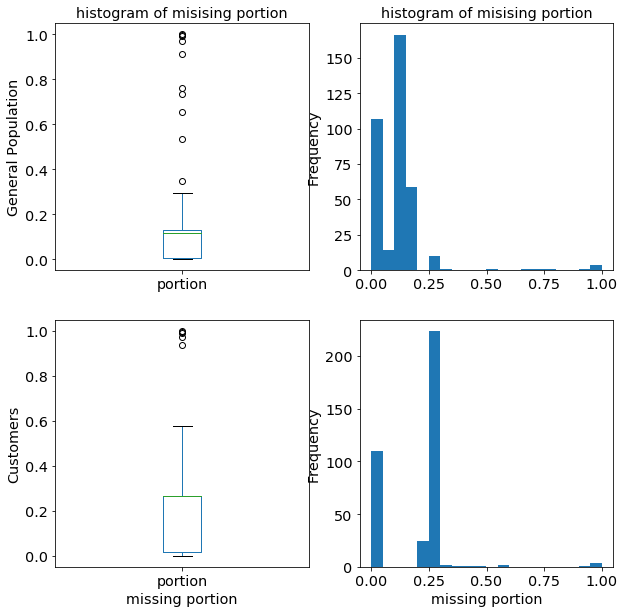

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

#general population
azdias_nareport['portion'].plot(kind='box',
                               title = 'histogram of misising portion',
                               ax=axes[0, 0])
axes[0,0].set(ylabel='General Population')

azdias_nareport['portion'].plot(kind='hist',
                                bins=20,
                               title = 'histogram of misising portion',
                               ax=axes[0, 1])

##customers
customers_nareport['portion'].plot(kind='box',
                               ax=axes[1, 0])
axes[1,0].set(xlabel='missing portion', ylabel='Customers')

customers_nareport['portion'].plot(kind='hist',
                                bins=20,
                               ax=axes[1, 1])
axes[1, 1].set(xlabel='missing portion');

In `General Population`, the outliers are 'missing portions' above .3, corresponding to the predefined threshold. There are ten columns having missing portions >= .3.

In `Customer Group`, the outliers are 'missing portions' above .8. There are 5 columns having missing portions >= .8.

Both group have the same top 10 columns but the missing portions are quite different in `AGER_TYP` and `EXTSEL992` groups. Arvato has collected more data in these two attributes than general population.

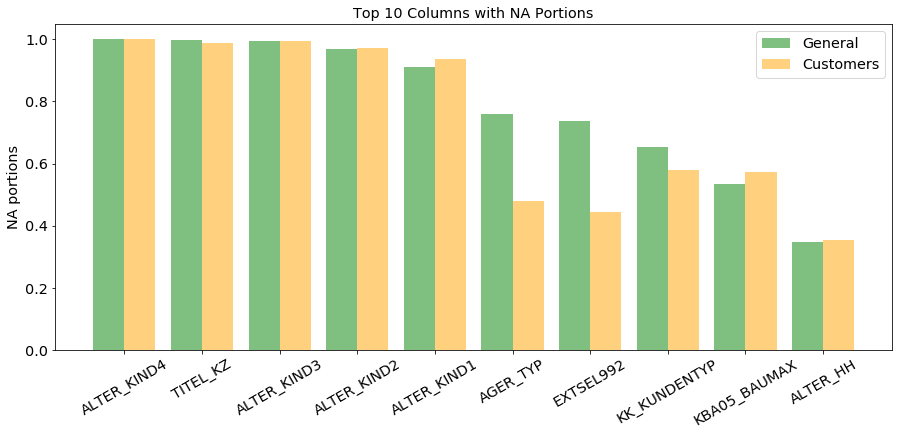

In [12]:
na_prop = azdias_nareport.head(10)[['portion']].join(customers_nareport.head(10)[['portion']], 
                                           how='outer', 
                                           lsuffix='_azdias',
                                          rsuffix='_customers').sort_values(by='portion_azdias', ascending=False)
bwidth = 0.4
x = np.arange(len(na_prop))

fig, ax = plt.subplots(figsize=(15, 6))


ax.bar(x, na_prop['portion_azdias'], width=bwidth, color='green', label='General', alpha=0.5)
ax.bar(x+bwidth, na_prop['portion_customers'], width=bwidth, color='orange', label='Customers', alpha=0.5)
ax.set_xticks(x+(bwidth/2))
ax.set_xticklabels(na_prop.index, rotation=30)
ax.set(ylabel='NA portions', title='Top 10 Columns with NA Portions')
ax.legend();

### Dropping columns with high missing values

Feature with high portion of missing values can rarely contribute to model prediction. I will discard the top 10 high level missing cols from both `Genaral` and `Customers` datasets.

In [13]:
col_to_drop = azdias_nareport.head(10).index.values.tolist()
col_to_drop = [i for i in col_to_drop if i not in customer_info]
col_to_drop = col_to_drop + ['D19_LETZTER_KAUF_BRANCHE'] #this column is not useful with many levels

start = time.time()
print(f'Dropping {col_to_drop} columns from Azdias and Customers Dataset...')

for df in [azdias, customers]:    
    df.drop(col_to_drop, axis=1, inplace=True)

end = time.time()
print(f'Succeed. Took {end-start:.1f} seconds.')
print(f'The shape of Azdias Dataset: {azdias.shape}')
print(f'The shape of Customers Dataset: {customers.shape}')

Dropping ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'ALTER_HH', 'D19_LETZTER_KAUF_BRANCHE'] columns from Azdias and Customers Dataset...
Succeed. Took 0.2 seconds.
The shape of Azdias Dataset: (89122, 355)
The shape of Customers Dataset: (19165, 358)


### Missing values in rows

In [14]:
print(f'number of rows with missing value:\n')
azd_cnt = sum(azdias.isnull().any(axis=1))
cust_cnt = sum(customers.isnull().any(axis=1))

print(f'In General Population: Total Counts: {azd_cnt}, portion {azd_cnt/len(azdias):.2f}')
print(f'In Customer Group: {cust_cnt}, portion {cust_cnt/len(customers):.2f}')

number of rows with missing value:

In General Population: Total Counts: 46625, portion 0.52
In Customer Group: 8072, portion 0.42


,General
count,89122.000000
mean,33.034223
std,74.873321
min,0.000000
25%,0.000000
50%,1.000000
60%,3.000000
75%,9.000000
80%,12.000000
90%,219.000000


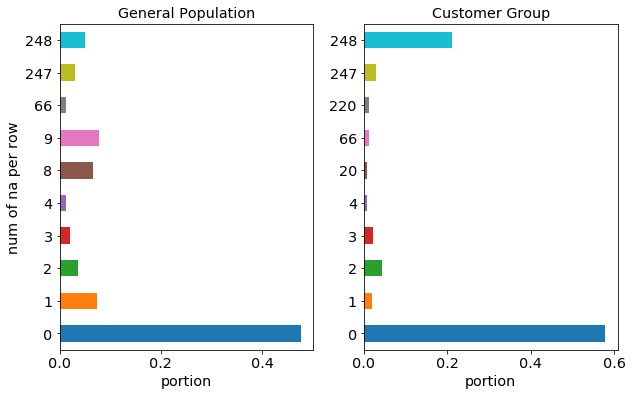

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

azd_na_row = azdias.isnull().sum(axis=1)
azd_na_rowpp = azd_na_row.value_counts(normalize=True)
azd_na_rowpp.head(10).sort_index().plot.barh(ax=axes[0])
axes[0].set(xlabel='portion', ylabel='num of na per row', title='General Population')

cust_na_row = customers.isnull().sum(axis=1)
cust_na_rowpp = cust_na_row.value_counts(normalize=True)
cust_na_rowpp.head(10).sort_index().plot.barh(ax=axes[1])
axes[1].set(xlabel='portion', title='Customer Group');

pct = [.25, .5, .6, .75, .8, .9]
df1 = azd_na_row.describe(percentiles=pct).to_frame('General')
df2 = cust_na_row.describe(percentiles=pct).to_frame('Customer')
display_side_by_side(df1, df2)

From above report, `General Population` has 80% of rows with less than 13 missing values, while in `Customer Group`, the portion is much less. In fact, `Customer Group`, about 25% of rows have 220 values out of 360 missing. We can further split the dataset into two groups: high informative group where less than 20 missing values missing per individual, and low informative group where more than 20 missing values missing per individual.

### Filter instances in High and Low Informative Group

In [16]:
mask_azd = azd_na_row <= 20
high_info_azd = azdias[mask_azd]
low_info_azd = azdias[~mask_azd]
print(f'Shape of High Informative General Group: {high_info_azd.shape}')
print(f'Shape of Low Informative General Group: {low_info_azd.shape}')


mask_cust = cust_na_row <=20
high_info_cust = customers[mask_cust]
low_info_cust = customers[~mask_cust]
print(f'Shape of High Informative Customer Group: {high_info_cust.shape}')
print(f'Shape of Low Informative Customer Group: {low_info_cust.shape}')

hazd_col = missing_summary(high_info_azd)
lazd_col = missing_summary(low_info_azd)

hcust_col = missing_summary(high_info_cust)
lcust_col = missing_summary(low_info_cust)

Shape of High Informative General Group: (73581, 355)
Shape of Low Informative General Group: (15541, 355)
Shape of High Informative Customer Group: (13302, 358)
Shape of Low Informative Customer Group: (5863, 358)


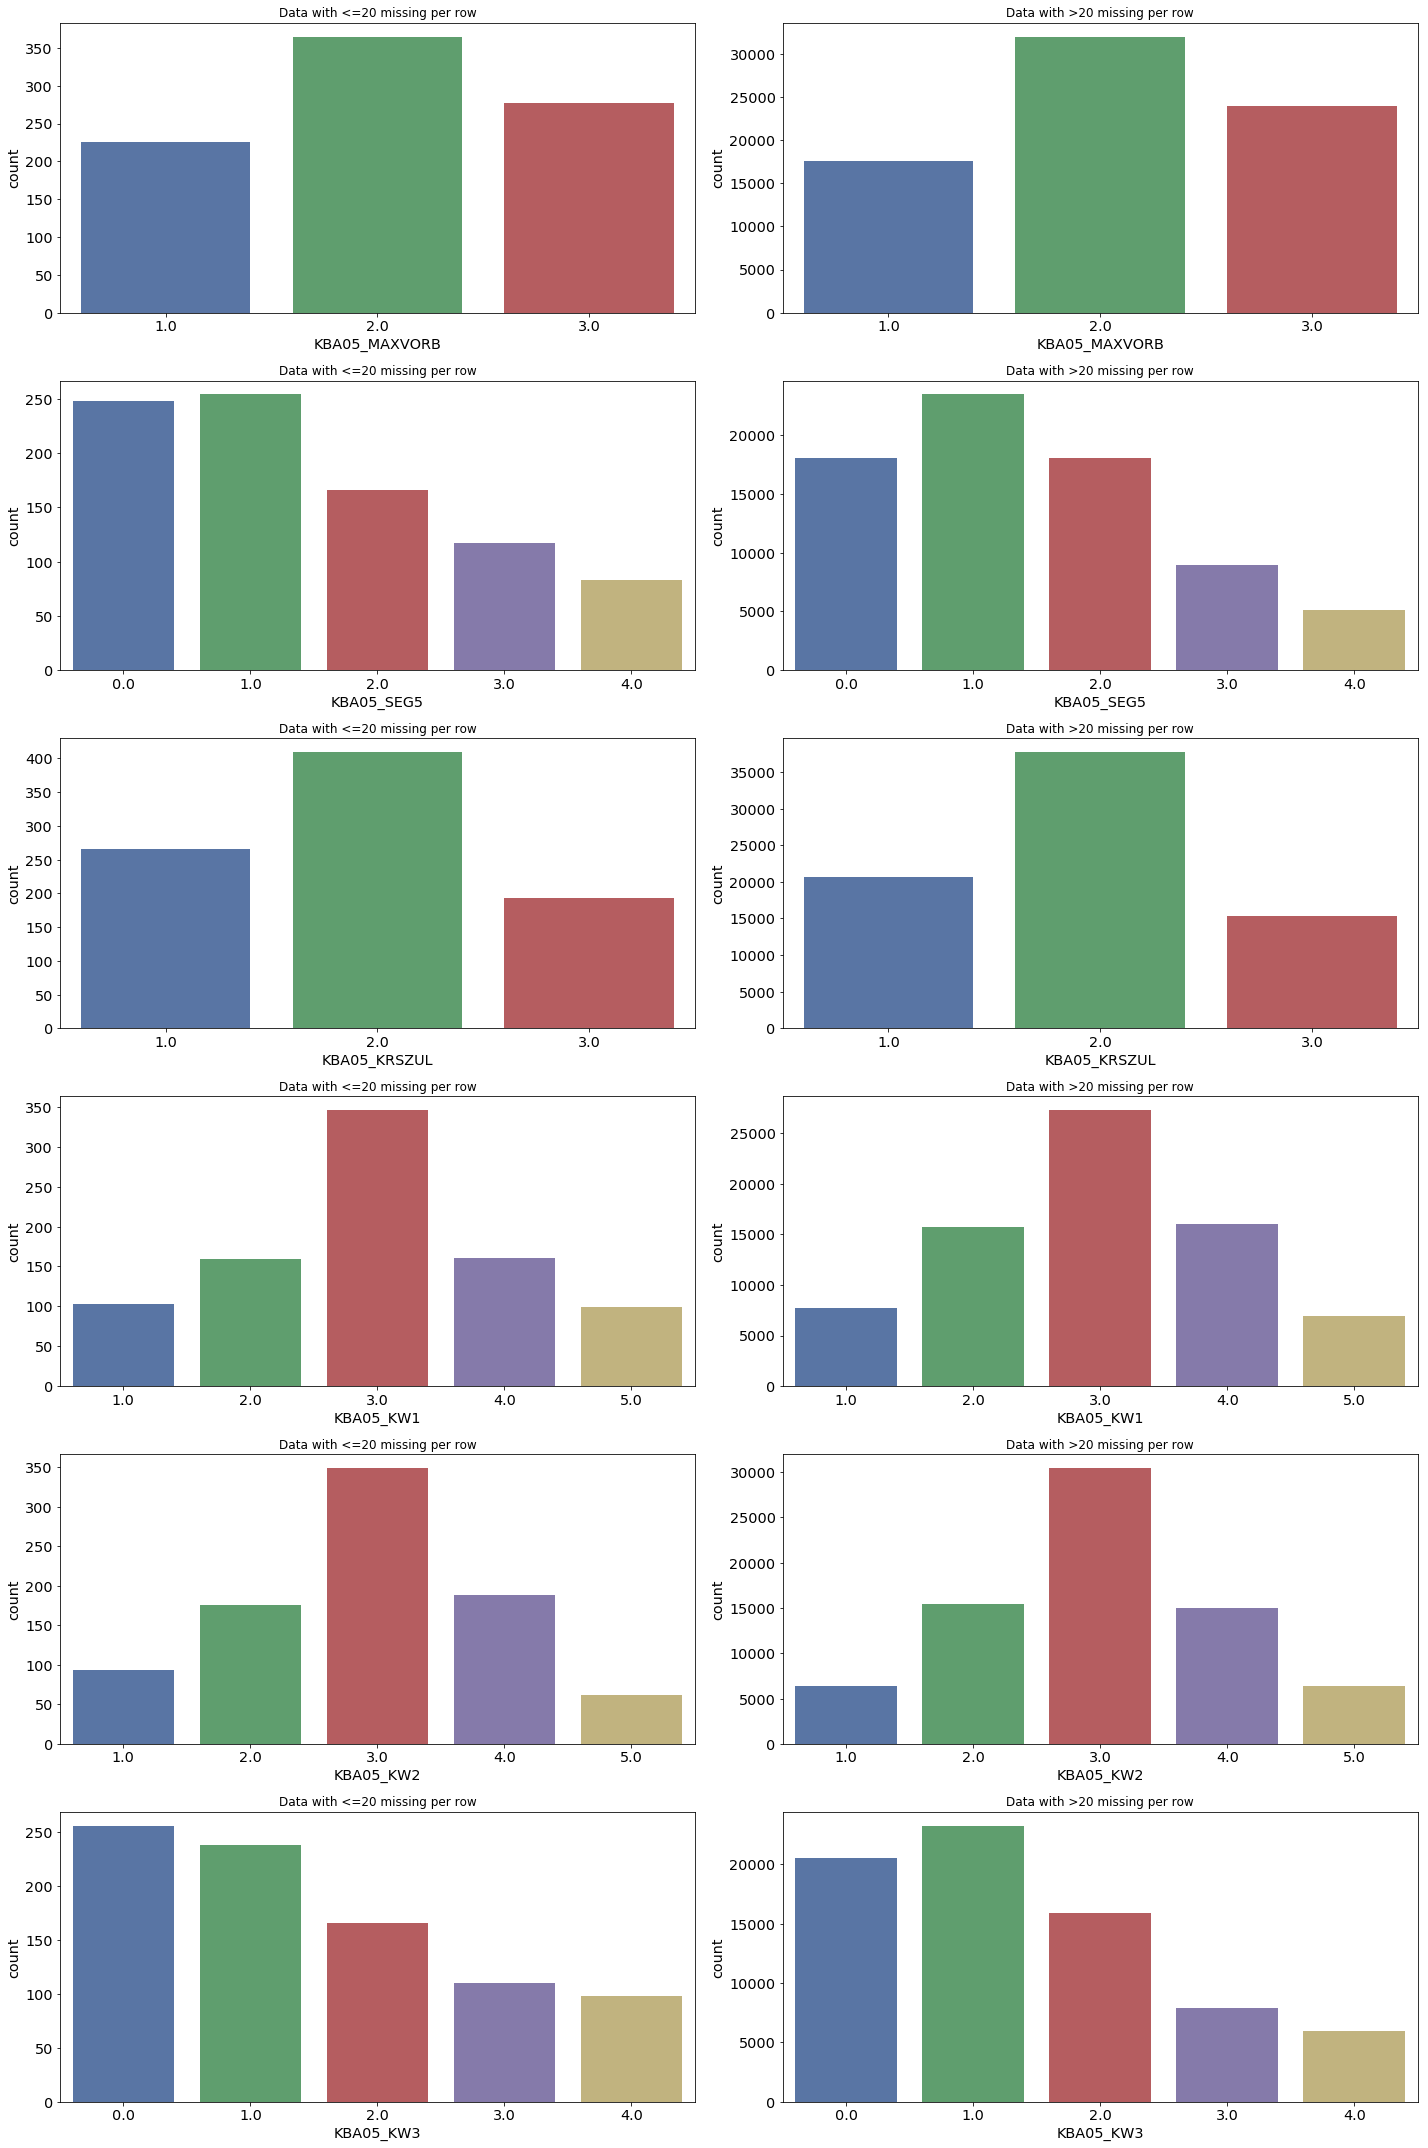

In [17]:
# compare the two groups in 6 columns

top6 = lazd_col.head(6).index.values.tolist()
fig, axes = plt.subplots(6, 2, figsize=(20, 30))

sns.set(style="darkgrid")
for n, col in enumerate(top6):
    sns.countplot(low_info_azd.loc[:, col], ax=axes[n,0])
    axes[n,0].set_title('Data with <=20 missing per row')
    sns.countplot(high_info_azd.loc[:, col], ax=axes[n,1])
    axes[n,1].set_title('Data with >20 missing per row')
    
plt.tight_layout()

### Encoding categorical  values into numerical values

According to the attributes summary provided by Arvato, majority of features are encoded from 1 to n number, with indication on ordinal ranking in the feature itself. This type of code does not need further encoding. However, for a few features, the feature does not contain an ordinal ranking, such as 

In [18]:
encoded_hlv_cust = encode_df(high_info_cust)
encoded_hlv_azd = encode_df(high_info_azd)

/home/workspace/Arvato_Customer_Segmentation/utils/preprocess.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].apply(lambda x: strtoint(x) if x is not np.nan else x)
/home/workspace/Arvato_Customer_Segmentation/utils/preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['CAMEO_DEUG_2015']= df['CAMEO_DEUG_2015'].astype('float64')
/home/workspace/Arvato_Customer_Segmentation/utils/preprocess.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

### Fill missing values with median

In [21]:
# extract the numerical features from both azdias and customers
num_df_azd = encoded_hlv_azd.select_dtypes(exclude='object')
num_df_cust = encoded_hlv_cust[num_df_azd.columns]

In [22]:
from sklearn.preprocessing import Imputer

#general population
imputer = Imputer(strategy='median')

start = time.time()
num_azd_cleaned = imputer.fit_transform(num_df_azd)
end = time.time()
print(f'Used {end-start:.2f} seconds.')
num_azd_cleaned = pd.DataFrame(num_azd_cleaned, index=num_df_azd.index, columns = num_df_azd.columns)

Used 4.69 seconds.


In [23]:
#customer
imputer = Imputer(strategy='median')

start = time.time()
num_cust_cleaned = imputer.fit_transform(num_df_cust)
end = time.time()
print(f'Used {end-start:.2f} seconds.')
num_cust_cleaned = pd.DataFrame(num_cust_cleaned, index=num_df_cust.index, columns = num_df_cust.columns)

Used 0.61 seconds.


### Feature Scaling

In [24]:
from sklearn.preprocessing import StandardScaler

#general population
scaler = StandardScaler()

start = time.time()
num_azd_scaled = scaler.fit_transform(num_azd_cleaned)
end = time.time()
print(f'Used {end-start:.2f} seconds.')
num_azd_scaled = pd.DataFrame(num_azd_scaled, index=num_df_azd.index, columns = num_df_azd.columns)

Used 1.00 seconds.


In [25]:
#customer
scaler = StandardScaler()

start = time.time()
num_cust_scaled = scaler.fit_transform(num_cust_cleaned)
end = time.time()
print(f'Used {end-start:.2f} seconds.')
num_cust_scaled = pd.DataFrame(num_cust_scaled, index=num_df_cust.index, columns = num_df_cust.columns)

Used 0.16 seconds.


### Get rid of highly correlated features

In [26]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, threshold=.6):
    au_corr = df.corr().abs().unstack().to_frame('corr')
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(by='corr', ascending=False)
    
    return au_corr[au_corr['corr']>threshold]

In [27]:
highly_corr = get_top_abs_correlations(num_azd_scaled)
print('Total number of highly correlated pairs {}'.format(len(highly_corr)))

Total number of highly correlated pairs 414


In [28]:
from collections import Counter
left_corr = Counter(highly_corr.index.get_level_values(0).value_counts().to_dict())
right_corr = Counter(highly_corr.index.get_level_values(1).value_counts().to_dict())
full_corr = left_corr + right_corr

to_drop = set()

for a, b in highly_corr.index:
    if full_corr[a] > full_corr[b]:
        to_drop.add(a)
    else:
        to_drop.add(b)

print(f'Number of highly correlated columns to drop {len(to_drop)}')

Number of highly correlated columns to drop 131


In [29]:
num_azd_scaled.drop(list(to_drop), inplace=True, axis=1)
num_cust_scaled.drop(list(to_drop), inplace=True, axis=1)
print('Final Shape of General Population: {}'.format(num_azd_scaled.shape))
print('Final Shape of Customer Group: {}'.format(num_cust_scaled.shape))

Final Shape of General Population: (73581, 225)
Final Shape of Customer Group: (13302, 225)


Update to_drop to include the newly found columns to drop

In [30]:
col_not_used = col_to_drop + list(to_drop)
print(len(set(col_not_used)))

142


In [34]:
name = 'col_unused.txt'
np.savetxt(name, col_not_used, delimiter=',', newline='\n', header='', footer='', fmt='%s')

### Dimension Reduction Using PCA

Use explained variances to choose number of components

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components = .95)
azd_pca = pca.fit_transform(num_azd_scaled)

In [36]:
def scree_plot(pca_estimator):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca_estimator.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca_estimator.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

The number components where cumulated explained variance is greater than .95.

In [38]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

181

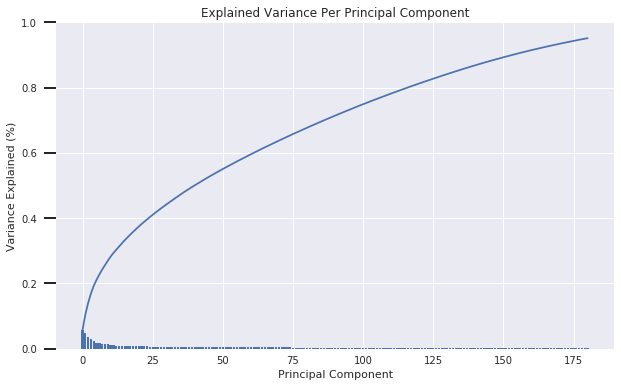

In [37]:
scree_plot(pca)

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=181)
azd_reduced = pca.fit_transform(num_azd_scaled)

### Component Makeup

In [42]:
#v: The makeup of the principal components
v = pca.components_

In [43]:
import seaborn as sns
"""Below code is refered from Udacity ML Engineer NanoDegree Segmentation Exercise"""
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component
    row_idx = component_num-1

    # get the list of weights from a row in v, numpy array
    v_1 = v[row_idx]

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

Interpretation of scores of each attribute in each component, check [here](https://www.researchgate.net/post/What_is_the_meaning_of_negative_values_in_components_from_PCA_analysis).

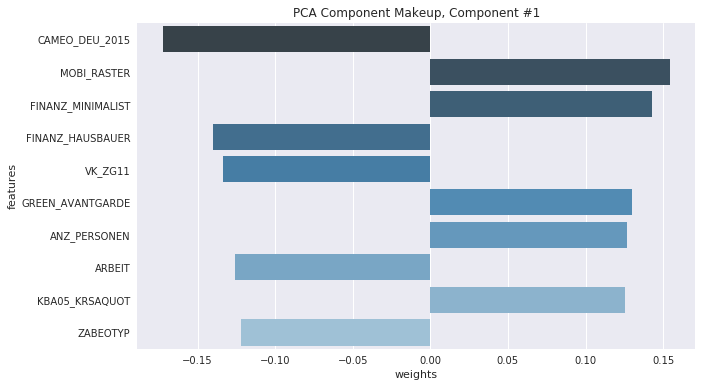

In [44]:
num = 1
display_component(v, num_azd_scaled.columns, num)

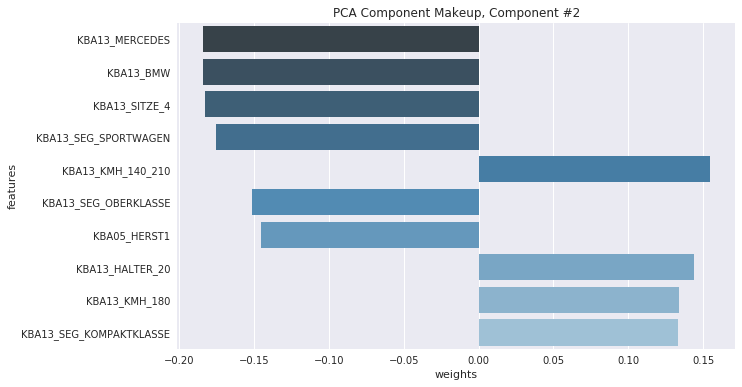

In [45]:
num = 2
display_component(v, num_azd_scaled.columns, num)

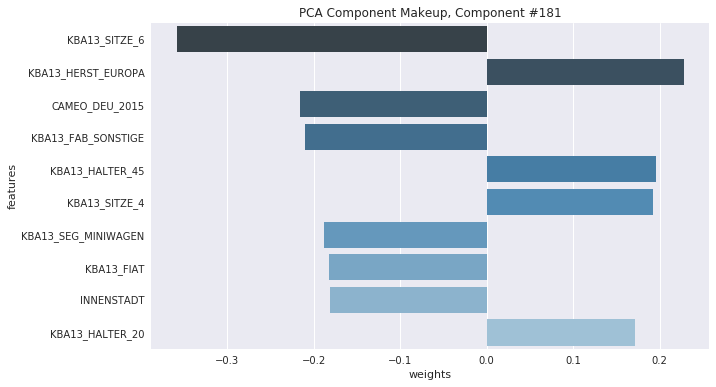

In [48]:
num = 181
display_component(v, num_azd_scaled.columns, num)

do the same dimension reduction on customer group


In [49]:
cust_reduced = pca.transform(num_cust_scaled)

In [50]:
cust_reduced.shape

(13302, 181)

## Clustering

### General Population

##### choosing optimal k clusters

* Using inertia

In [51]:
from sklearn.cluster import KMeans

kmeans_per_k_azd = [KMeans(n_clusters=k, random_state=42).fit(azd_reduced) for k in range(2, 30, 2)]

In [52]:
len(kmeans_per_k_azd)

14

In [53]:
import pickle
filename = 'kmeans_azd_k2_k30_14.sav'
pickle.dump(kmeans_per_k_azd, open(filename, 'wb'))

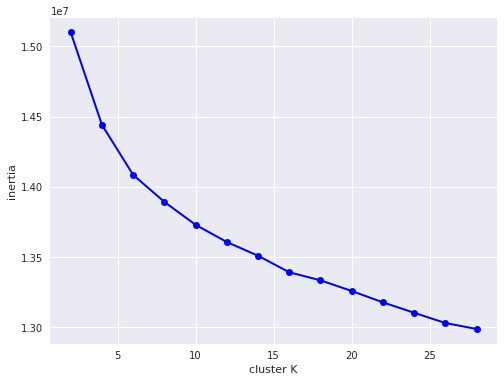

In [58]:
inertias = [model.inertia_ for model in kmeans_per_k_azd]
plt.figure(figsize=(8, 6))
plt.plot(range(2, 30, 2), inertias, 'bo-', linewidth=2)
plt.xlabel('cluster K')
plt.ylabel('inertia');

* Using silhouette scores

In [60]:
from sklearn.metrics import silhouette_score

silhouette_scores_azd = [silhouette_score(azd_reduced, model.labels_, sample_size=5000) for model in kmeans_per_k_azd]

Text(0,0.5,'silhouette score')

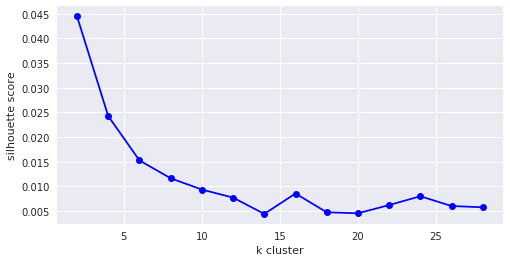

In [62]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 30, 2), silhouette_scores_azd, 'bo-')
plt.xlabel('k cluster')
plt.ylabel('silhouette score')

* choose best k

In [65]:
best_k= [8, 10, 12, 14, 16]
model_ind = [int(k/2) for k in best_k] 
#best_models = kmeans_per_k_azd[model_ind]
best_model = kmeans_per_k_azd[4]

* predict clusters on customer group

In [67]:
predict_customers = best_model.predict(cust_reduced)

* Compare Customer Data to Demographics Data

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

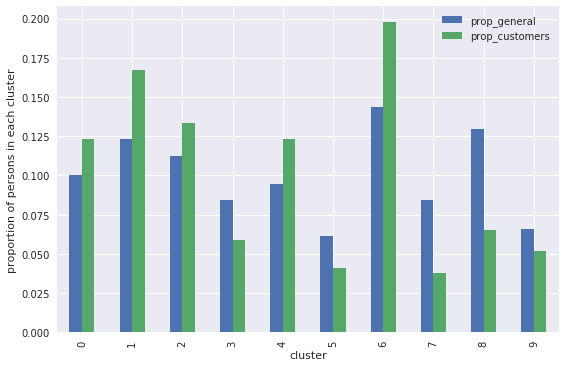

In [96]:
general_prop = []
customers_prop = []
x = [i for i in range(10)]

for i in range(10):
    general_prop.append((best_model.labels_ == i).sum()/len(best_model.labels_))
    customers_prop.append((predict_customers == i).sum()/len(predict_customers))


df = pd.DataFrame({'cluster' : x, 'prop_general' : general_prop, 'prop_customers':customers_prop})
df.plot(x='cluster', y = ['prop_general', 'prop_customers'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

In [90]:
centroids = best_model.cluster_centers_
print(f'shape of centroids: {centroids.shape}')

shape of centroids: (10, 181)


In [93]:
# get all the centroids
cluster_centroids=pd.DataFrame(centroids)
cluster_centroids.columns=['PCA_'+ str(i) for i in range(1, 182)]
pcatop10 = cluster_centroids.iloc[:, :10]
display(pcatop10)

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,2.398913,0.961098,3.172174,0.808091,0.042274,-0.467965,0.483987,-0.149849,-0.383317,0.072321
1,1.548591,0.568344,-0.789872,-3.746141,-0.585442,0.382851,-0.175111,-0.148471,-0.084280,0.086787
2,3.225770,-0.766969,-2.742134,0.764898,-0.459007,-0.271531,0.348011,0.230384,-0.342293,-0.089586
3,-3.679362,-2.039326,1.997927,1.333694,-1.002690,1.350073,-1.275319,0.393501,0.453030,-1.089906
4,1.707433,-5.463622,-0.279852,0.654338,1.045955,-0.515497,0.023287,0.145909,0.755906,-0.030218
5,-0.444667,4.969967,-1.793639,-1.330601,1.772538,-0.375010,-0.821408,0.351658,1.414858,-1.097900
6,-2.474158,-0.706245,-1.805515,0.629524,-1.487211,0.186849,0.149145,-0.494334,-0.773562,0.492485
7,-4.467086,3.191025,-1.281100,1.867563,2.660503,-0.186780,0.500719,0.282540,0.780156,-0.235466
8,-2.300356,-0.843481,2.476210,-1.391805,0.224680,-0.625720,0.509381,-0.036506,-0.468440,0.700311
9,6.270290,3.699776,1.559963,2.050336,-0.674784,0.877127,-0.600697,-0.142062,-0.059656,0.195917


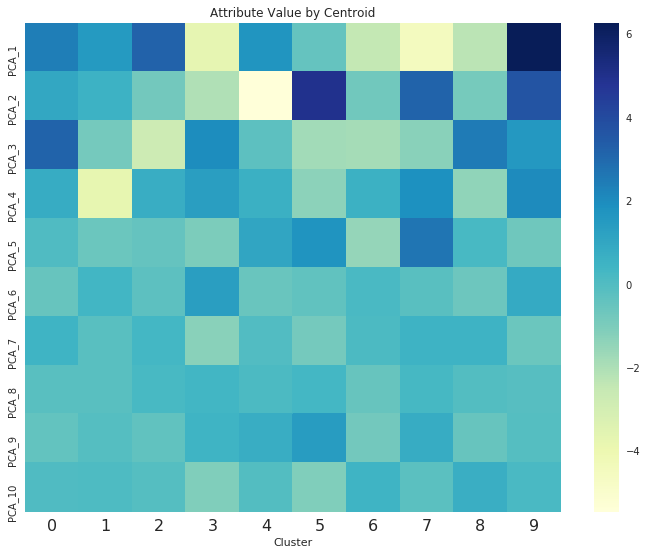

In [95]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(pcatop10.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

Put the labels/cluter index to the original unscaled general group and customer group.

In [129]:
high_info_azd['Group'] = best_model.labels_
high_info_cust['Group'] = predict_customers

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


* Overrepresented

Which cluster or clusters are overrepresented in the customer dataset compared to the general population?

Cluster 0, 1, 2, 4, 6

In [133]:
cluster0_gp = high_info_azd[high_info_azd['Group']==0]
cluster0_cust = high_info_cust[high_info_cust['Group']==0]

PCA 3 and PCA 1 are quite significant in cluster 0. In PCA 3, `ALTERSKATEGORIE_FEIN` and `CJT_TYP_4` are the top contributors. We can take a look from these two clusters under these two features.

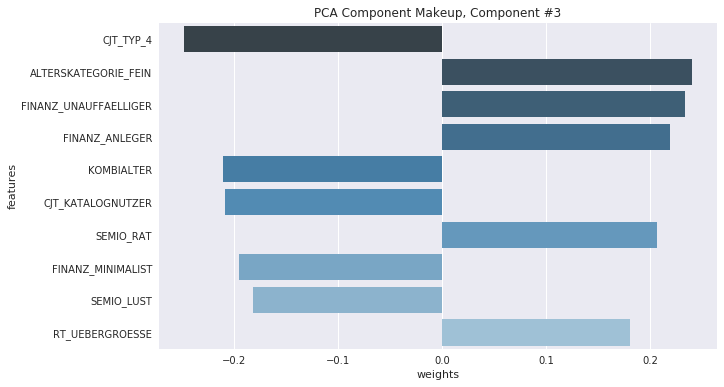

In [124]:
num=3
display_component(v, num_azd_scaled.columns, num)

Retrieve to the original unconverted data for this cluster.

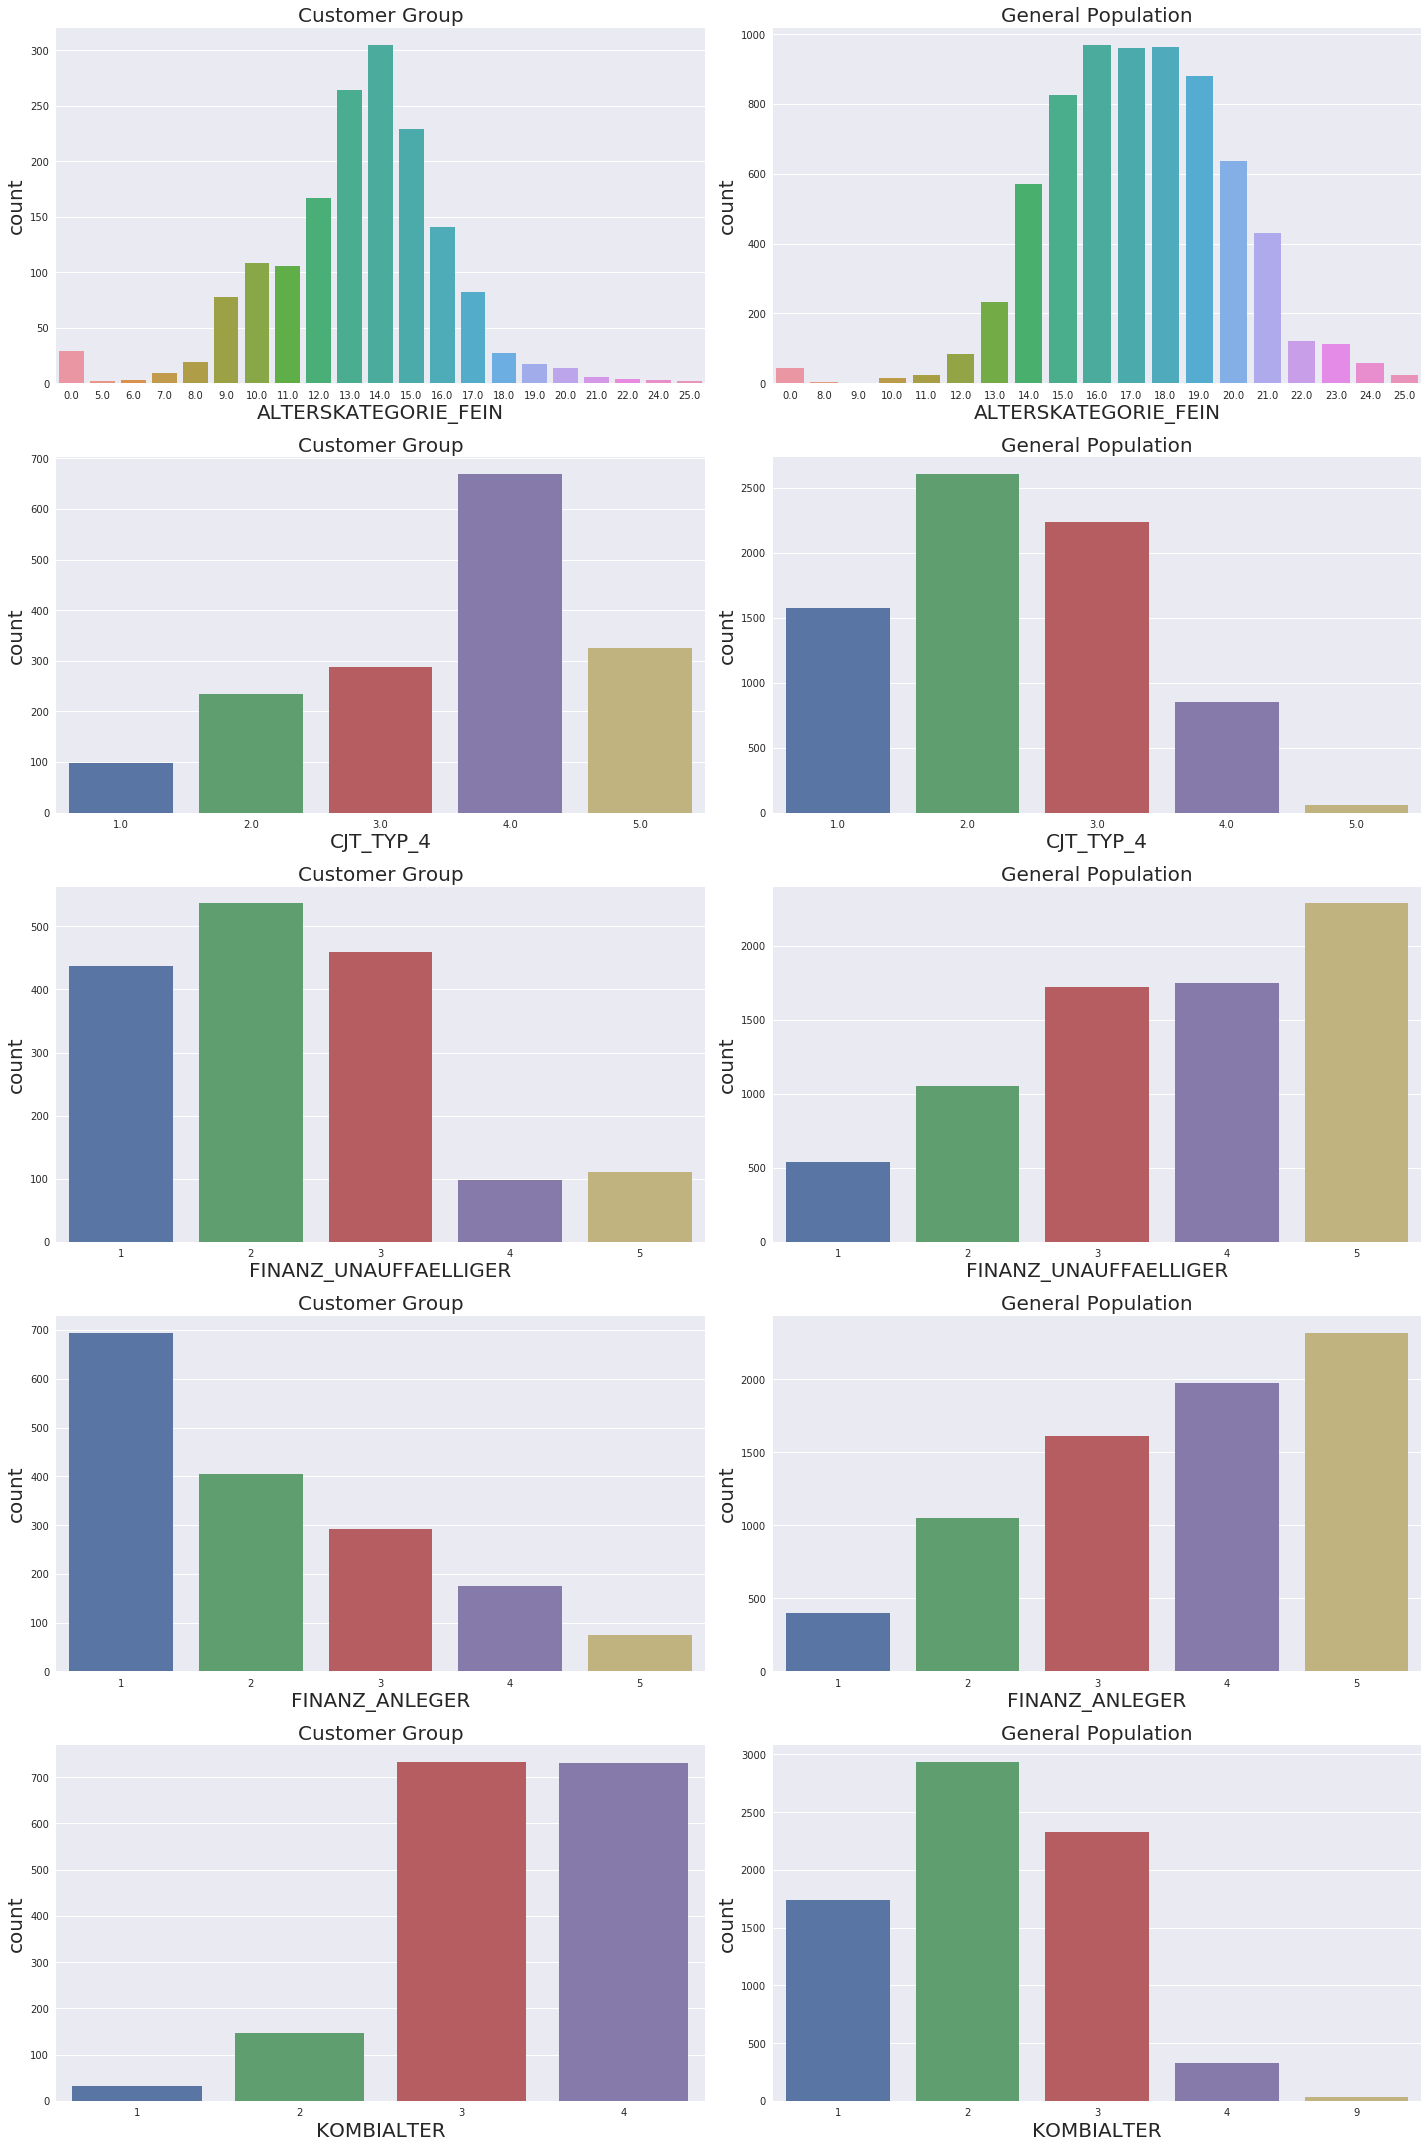

In [141]:
cols = ['ALTERSKATEGORIE_FEIN', 'CJT_TYP_4', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_ANLEGER', 'KOMBIALTER']

rows = len(cols)

fig, axes = plt.subplots(rows, 2, figsize=(20, 30))

sns.set(style="darkgrid")
for n, col in enumerate(cols):
    sns.countplot(cluster0_cust.loc[:, col], ax=axes[n, 0])
    axes[n,0].set_title('Customer Group', fontsize=20)
    axes[n,0].xaxis.label.set_size(20)
    axes[n,0].yaxis.label.set_size(20)
    
    sns.countplot(cluster0_gp.loc[:, col], ax=axes[n, 1])
    axes[n,1].set_title('General Population', fontsize=20)
    axes[n,1].xaxis.label.set_size(20)
    axes[n,1].yaxis.label.set_size(20)

plt.tight_layout()

* Underrepresented

Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Cluster 3, 5, 7, 8, 9

In [142]:
cluster_num = 8
cluster8_gp = high_info_azd[high_info_azd['Group']==cluster_num]
cluster8_cust = high_info_cust[high_info_cust['Group']==cluster_num]

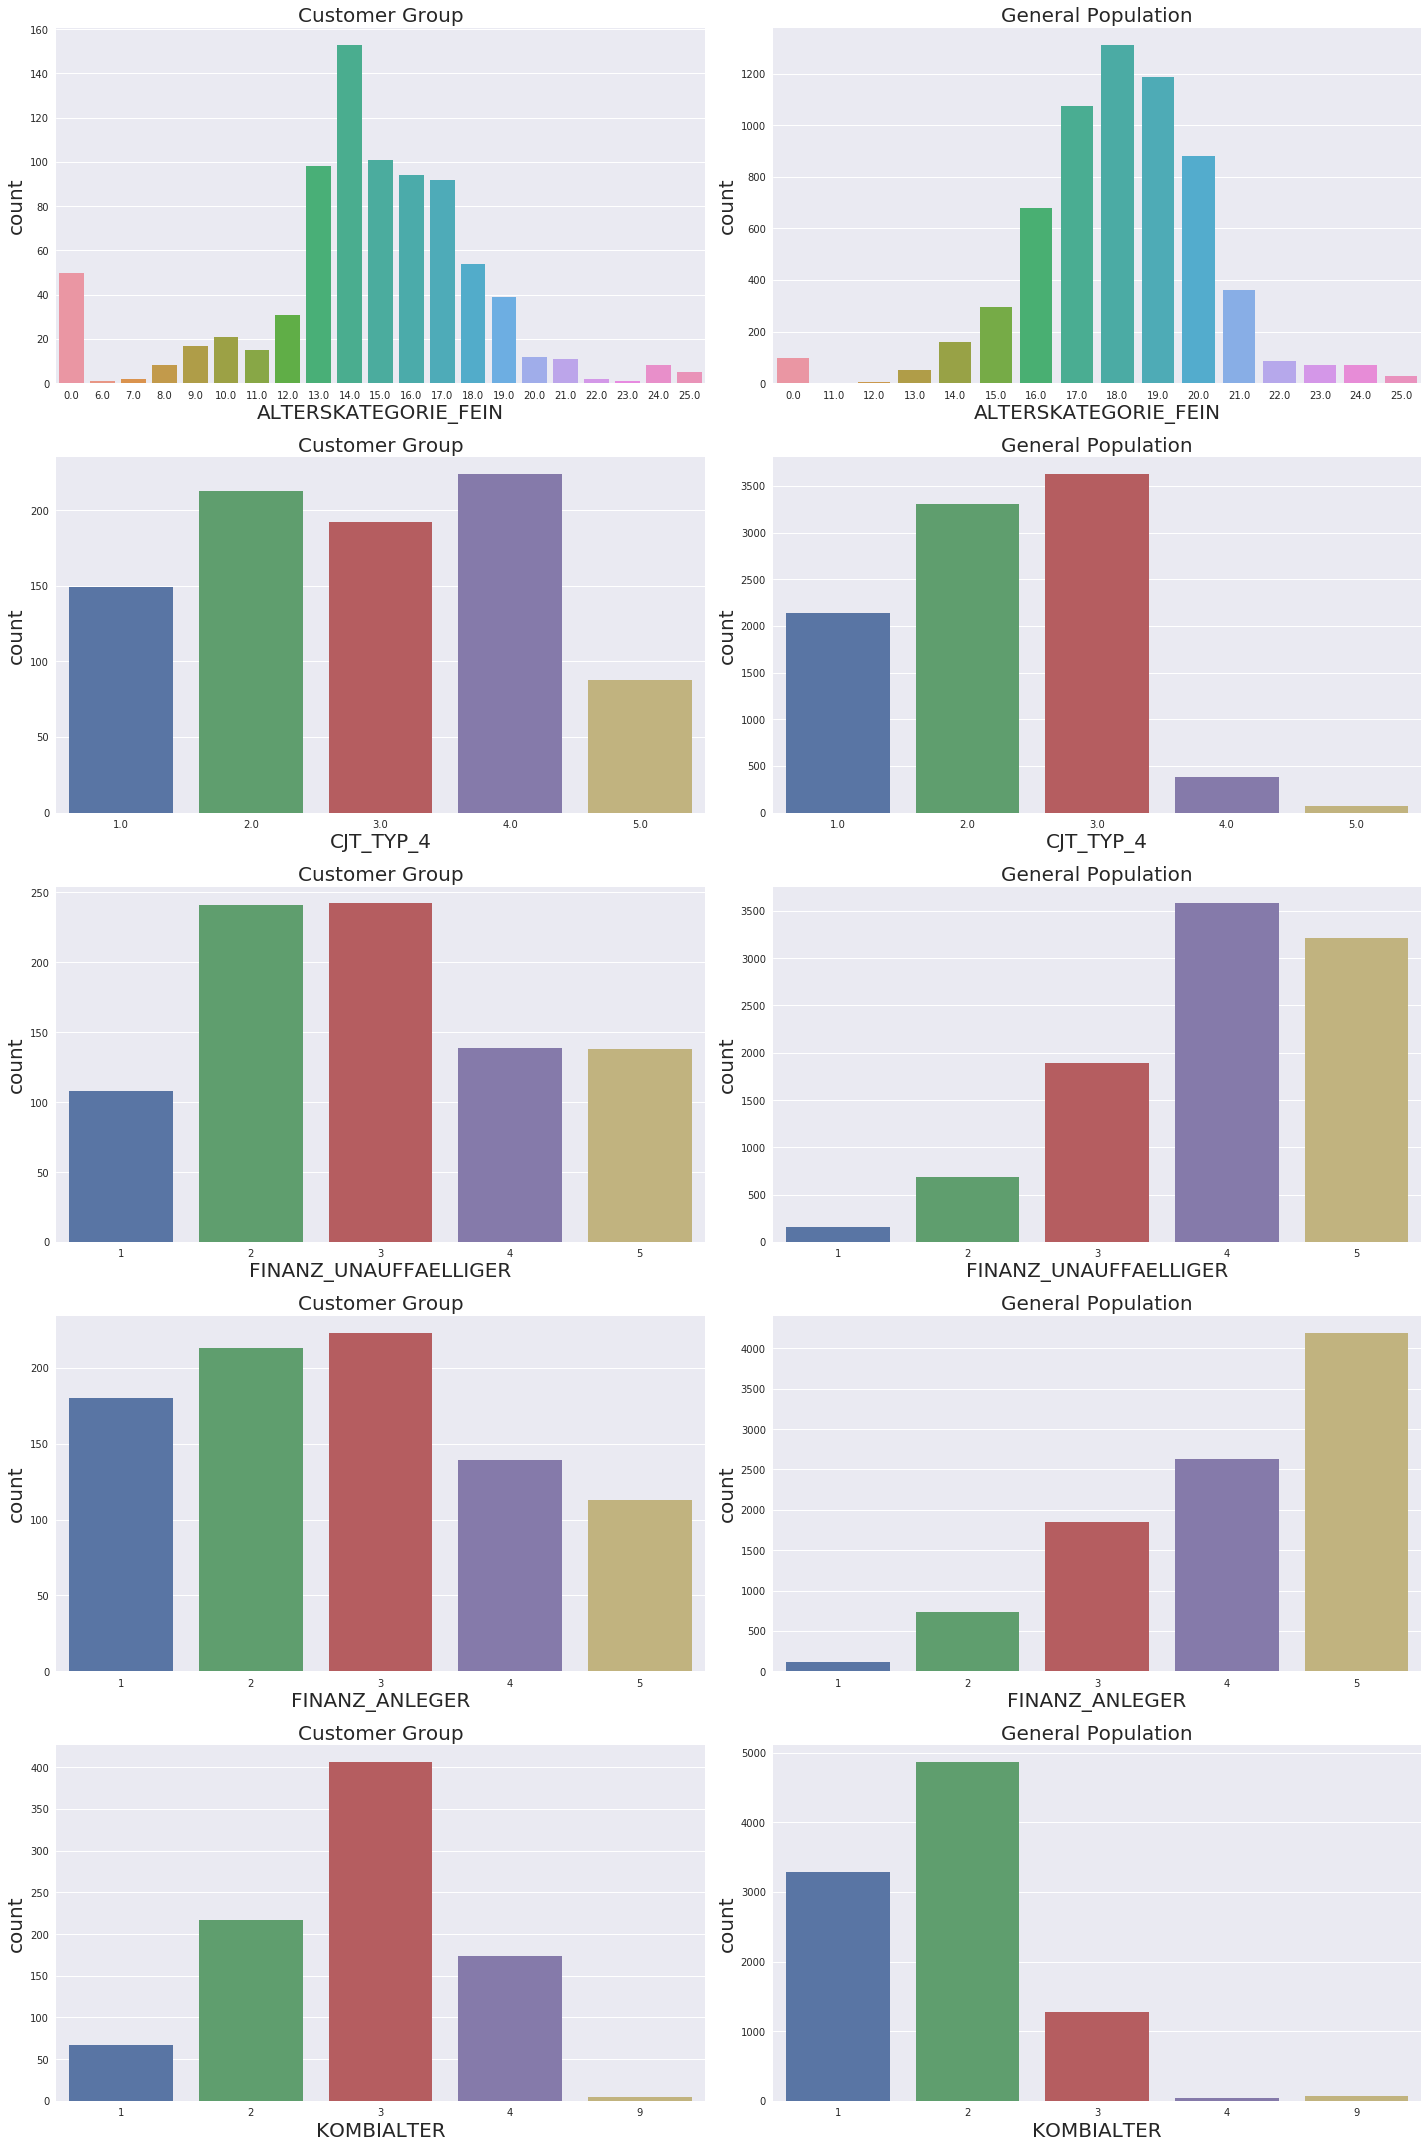

In [143]:

cols = ['ALTERSKATEGORIE_FEIN', 'CJT_TYP_4', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_ANLEGER', 'KOMBIALTER']

rows = len(cols)

fig, axes = plt.subplots(rows, 2, figsize=(20, 30))

sns.set(style="darkgrid")
for n, col in enumerate(cols):
    sns.countplot(cluster8_cust.loc[:, col], ax=axes[n, 0])
    axes[n,0].set_title('Customer Group', fontsize=20)
    axes[n,0].xaxis.label.set_size(20)
    axes[n,0].yaxis.label.set_size(20)
    
    sns.countplot(cluster8_gp.loc[:, col], ax=axes[n, 1])
    axes[n,1].set_title('General Population', fontsize=20)
    axes[n,1].xaxis.label.set_size(20)
    axes[n,1].yaxis.label.set_size(20)

plt.tight_layout()

## Conclusion

In this project, I use K-means clustering techniques to segment general poulation into 10 clusters. The model is also predicted on Customer Data. The mismatch of people portion of clusters between these two datasets indicated the potential customer characteristics favored by company. To look into the customer profile, I also revert to PCA heatmap and the top 5 original features with highest weights. Companies can build a recommend system center around these features for the potential customers.